# Misfit Verification Tests

In [1]:
%matplotlib inline
from IPython import display
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy.stats import beta, expon, truncnorm, norm, uniform
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re
import copy
from matplotlib import cm

pd.options.display.float_format = '{:,g}'.format
plt.style.use(['ggplot'])

## Creating a Simplified Synthetic Dataset

In [2]:
filename = "./data/colima/colima_real_data.csv"

obs_df, grid = io.import_colima(filename)

grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

display.display(grid)

,Easting,Northing,Elevation
16,1499,1506,0
18,1957,1997,0
17,1787,2173,0
37,-770,3082,0
31,-1673,3152,0
36,-637,4876,0
35,-1268,5048,0
34,-2101,5517,0
33,-2250,5771,0
32,-2272,5925,0


In [3]:
config = io.read_tephra2_config("data/colima/colima_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

# Update parameters
# COL STEPS need to be small enough so the 
# layer height can be kept for an inversion with a high H
config["COL_STEPS"] = 20
theoretical_max = 45000 #The H value will be as close as possible to this
layer_thickness = ((config["PLUME_HEIGHT"]-config["VENT_ELEVATION"])/config["COL_STEPS"])

inversion_steps = np.round((config["COL_STEPS"]*(theoretical_max - config["VENT_ELEVATION"]))/\
                  (config["PLUME_HEIGHT"]-config["VENT_ELEVATION"]))
closest_H = ((inversion_steps*(config["PLUME_HEIGHT"] - config["VENT_ELEVATION"]))/\
             config["COL_STEPS"]) + config["VENT_ELEVATION"]
print("This number needs to be low enough to invert efficiently:")
print(inversion_steps)
print("If not, decrease COL_STEPS or theoretical max")
print("Closest Possible Theoretical Max Column Height:")
print(closest_H)

config["INV_STEPS"] = int(inversion_steps)
config["THEO_MAX_COL"] = closest_H
config["PART_STEPS"] = 9

config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

# Parameter Simplification
config["ALPHA"] = 1
config["BETA"] = 1


print("INPUT PARAMETERS:")
display.display(config)
display.display(globs)

This number needs to be low enough to invert efficiently:
40.0
If not, decrease COL_STEPS or theoretical max
Closest Possible Theoretical Max Column Height:
44915.0
INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1,
 'BETA': 1,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'INV_STEPS': 40,
 'THEO_MAX_COL': 44915.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

,centroid,density,interval,lower,probability,upper
0,-4.5,"1,024","[-5,-4)",-5,0.0683375,-4
1,-3.5,"1,024","[-4,-3)",-4,0.109203,-3
2,-2.5,"1,024","[-3,-2)",-3,0.146694,-2
3,-1.5,"1,024","[-2,-1)",-2,0.16565,-1
4,-0.5,"1,024","[-1,0)",-1,0.157243,0
5,0.5,"1,233.5","[0,1)",0,0.125474,1
6,1.5,"1,443","[1,2)",1,0.0841661,2
7,2.5,"1,652.5","[2,3)",2,0.0474595,3
8,3.5,"1,862","[3,4)",3,0.0224962,4


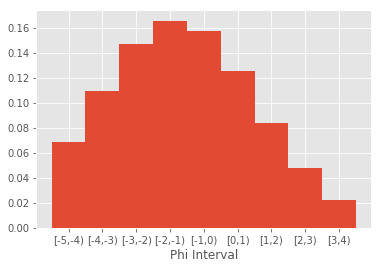

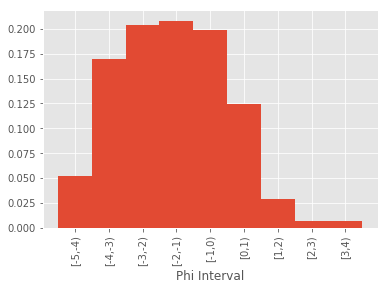

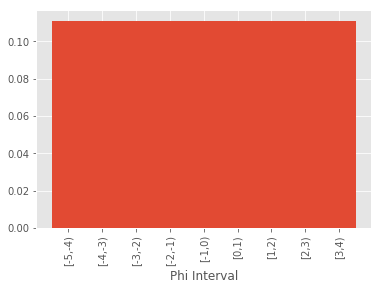

In [4]:
theo_phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display.display(pd.DataFrame(theo_phi_steps))



probs = [phi["probability"].copy() for phi in theo_phi_steps]
x = [phi["centroid"] for phi in theo_phi_steps]
labels = [phi["interval"] for phi in theo_phi_steps]
fig, ax = plt.subplots(facecolor='w', edgecolor='k')
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.show()

naive_tgsd = get_tgsd(obs_df, theo_phi_steps)

fig, ax = plt.subplots(facecolor='w', edgecolor='k')
ax.bar(x, naive_tgsd, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.xlabel("Phi Interval")
plt.show()

naive_phi_steps = theo_phi_steps.copy()
for i, phi in enumerate(naive_phi_steps):
    phi["probability"] = naive_tgsd[i]


uniform_tgsd = [1/len(theo_phi_steps)]*len(theo_phi_steps)

fig, ax = plt.subplots(facecolor='w', edgecolor='k')
ax.bar(x, uniform_tgsd, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.xlabel("Phi Interval")
plt.show()

uniform_phi_steps = theo_phi_steps.copy()
for i, phi in enumerate(uniform_phi_steps):
    phi["probability"] = uniform_tgsd[i]


In [5]:

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(55)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)

forward_df = gaussian_stack_forward(
    grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
    config["PLUME_HEIGHT"], 2500, uniform_phi_steps, (config["ALPHA"], config["BETA"]), 
    config["ERUPTION_MASS"], 
    (u,v), config["DIFFUSION_COEFFICIENT"], config["EDDY_CONST"],
    config["FALL_TIME_THRESHOLD"]
)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values
display.display(forward_df)

print(u, v)

,Northing,Easting,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",MassArea,radius,Residual
0,1506,1499,32.0404,26.5116,18.9048,12.0808,7.04104,2.85853,0.530721,0.0320454,0.000126451,"1,056.85","2,124.86",1.6888
1,1997,1957,27.8933,25.9041,19.784,13.2379,8.29897,3.91702,0.900806,0.0636282,0.000276626,929.936,"2,796.04",2.22899
2,2173,1787,27.679,25.8711,19.8452,13.3087,8.3571,3.95815,0.91552,0.0649594,0.000283183,955.453,"2,813.41",1.90846
3,3082,-770,29.6648,26.3865,19.1887,12.244,7.59041,3.83089,1.01442,0.079938,0.00037644,292.78,"3,176.73",0.492473
4,3152,-1673,30.8581,26.9211,18.9342,11.5164,6.9066,3.64421,1.11891,0.099899,0.00051777,116.058,"3,568.48",0.927277
5,4876,-637,18.3729,24.2096,23.2235,16.4711,9.8259,5.18058,2.36711,0.346732,0.00249788,164.221,"4,917.43",0.984067
6,5048,-1268,18.148,24.3658,23.5843,16.5662,9.59914,4.93546,2.40126,0.396754,0.00313217,92.2982,"5,204.82",0.737441
7,5517,-2101,15.6972,23.6021,24.8497,17.9549,9.95074,4.80579,2.56371,0.570252,0.00573045,35.1613,"5,903.52",0.374574
8,5771,-2250,14.0754,22.7517,25.4113,18.9848,10.4722,4.94592,2.67823,0.672861,0.00752675,27.4755,"6,194.11",0.439046
9,5925,-2272,13.0928,22.1373,25.6757,19.6452,10.8625,5.08067,2.7595,0.737604,0.00873743,25.3408,"6,345.68",0.404935


5.7357643635104605 8.191520442889917


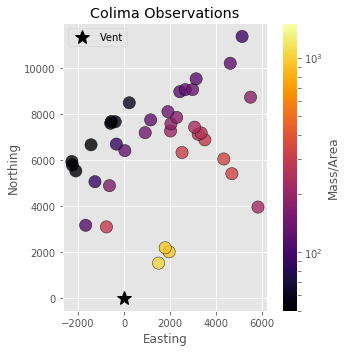

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

vis.plot_sample(forward_df, vent=(0,0), log=True, bounds=(50, 1500),
            title="Colima Observations", cbar_label="Mass/Area", ax = ax)
plt.tight_layout()
plt.show()

In [35]:
test_config = config.copy()

test_config["VENT_ELEVATION"] = 1
test_config["PLUME_HEIGHT"] = 5000
test_config["ALPHA"] = 1
test_config["BETA"] = 1
test_config["ERUPTION_MASS"] = 100000
test_config["MAX_GRAINSIZE"] = 0
test_config["MIN_GRAINSIZE"] = 1
test_config["MEDIAN_GRAINSIZE"] = 0.5
test_config["STD_GRAINSIZE"] = 0.5
test_config["DIFFUSION_COEFFICIENT"] = 1000
test_config["FALL_TIME_THRESHOLD"] = 1
test_config["COL_STEPS"] = 5
test_config["PART_STEPS"] = 2
test_config["INV_STEPS"] = 6
test_config["THEO_MAX_COL"] = 6000


u = 1
v = 1

display.display(test_config)

test_phi_steps = get_phi_steps(test_config["MIN_GRAINSIZE"], test_config["MAX_GRAINSIZE"], 
                          test_config["PART_STEPS"], 
                          test_config["MEDIAN_GRAINSIZE"], test_config["STD_GRAINSIZE"],
                          1000, 
                          1000, 
                          1000, 1000)
step_width = (test_config["MAX_GRAINSIZE"] - test_config["MIN_GRAINSIZE"])/test_config["PART_STEPS"]
for i, phi in enumerate(test_phi_steps):
    phi["probability"] = 1/test_config["PART_STEPS"]
display.display(pd.DataFrame(test_phi_steps))

{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 1,
 'PLUME_HEIGHT': 5000,
 'ALPHA': 1,
 'BETA': 1,
 'ERUPTION_MASS': 100000,
 'MAX_GRAINSIZE': 0,
 'MIN_GRAINSIZE': 1,
 'MEDIAN_GRAINSIZE': 0.5,
 'STD_GRAINSIZE': 0.5,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 1000,
 'FALL_TIME_THRESHOLD': 1,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 5,
 'PART_STEPS': 2,
 'PLUME_MODEL': 2.0,
 'INV_STEPS': 6,
 'THEO_MAX_COL': 6000,
 'WIND_SPEED': 10}

,centroid,density,interval,lower,probability,upper
0,0.25,1000,"[0,0.5)",0,0.5,0.5
1,0.75,1000,"[0.5,1)",0.5,0.5,1


In [41]:
#Test DF

grid_locations = {'Northing': [1000], 'Easting': [1000]}

test_grid = pd.DataFrame(data=grid_locations)

test_df = gaussian_stack_forward(
    test_grid, int(test_config["COL_STEPS"]), test_config["VENT_ELEVATION"], 
    test_config["PLUME_HEIGHT"], 1, test_phi_steps, (test_config["ALPHA"], test_config["BETA"]), 
    test_config["ERUPTION_MASS"], 
    (u,v), test_config["DIFFUSION_COEFFICIENT"], test_config["EDDY_CONST"],
    test_config["FALL_TIME_THRESHOLD"], debug=True
)

test_df["radius"] = np.sqrt(test_df["Easting"]**2 + test_df["Northing"]**2)
test_df = test_df.sort_values(by=['radius'])
display.display(test_df)



,Release Height (z),Suspended Mass (q),Ash Diameter,Particle Density,Fall Time,Total Fall Time,Fall Time Adj,X Adj,Y Adj,Terminal Velocity,Col Spead Coarse,Col Spead Fine,Diffusion,Avg. Wind Angle,Avg. Wind Speed,Wind Sum x,Wind Sum y,Windspeed Adj,U wind adj,V wind adj
0,"1,000.8","16,666.7",0.001,"1,000",230.526,230.526,0,0,0,-4.33703,3.19872,131.93,"160,073",0.785398,1.41421,230.526,230.526,1.41421,1,1
1,"2,000.6","16,666.7",0.001,"1,000",221.345,451.871,0,0,0,-4.51693,12.7949,229.703,"776,181",0.785398,1.41421,451.871,451.871,1.41421,1,1
2,"3,000.4","16,666.7",0.001,"1,000",212.529,664.401,0,0,0,-4.70429,28.7885,317.716,1.93459e+06,0.785398,1.41421,664.401,664.401,1.41421,1,1
3,"4,000.2",0,0.001,"1,000",204.065,868.466,0,0,0,-4.89942,51.1795,399.936,3.66709e+06,0.785398,1.41421,868.466,868.466,1.41421,1,1
4,"5,000",0,0.001,"1,000",195.938,"1,064.4",0,0,0,-5.10265,79.968,478.1,5.9806e+06,0.785398,1.41421,"1,064.4","1,064.4",1.41421,1,1


,Release Height (z),Suspended Mass (q),Ash Diameter,Particle Density,Fall Time,Total Fall Time,Fall Time Adj,X Adj,Y Adj,Terminal Velocity,Col Spead Coarse,Col Spead Fine,Diffusion,Avg. Wind Angle,Avg. Wind Speed,Wind Sum x,Wind Sum y,Windspeed Adj,U wind adj,V wind adj
0,"1,000.8","16,666.7",0.000707107,"1,000",326.013,326.013,0,0,0,-3.06675,3.19872,131.93,"287,216",0.785398,1.41421,326.013,326.013,1.41421,1,1
1,"2,000.6","16,666.7",0.000707107,"1,000",313.029,639.042,0,0,0,-3.19395,12.7949,229.703,1.42368e+06,0.785398,1.41421,639.042,639.042,1.41421,1,1
2,"3,000.4","16,666.7",0.000707107,"1,000",300.562,939.604,0,0,0,-3.32644,28.7885,317.716,3.58753e+06,0.785398,1.41421,939.604,939.604,1.41421,1,1
3,"4,000.2",0,0.000707107,"1,000",288.591,"1,228.2",0,0,0,-3.46441,51.1795,399.936,6.84548e+06,0.785398,1.41421,"1,228.2","1,228.2",1.41421,1,1
4,"5,000",0,0.000707107,"1,000",277.097,"1,505.29",0,0,0,-3.60812,79.968,478.1,1.12125e+07,0.785398,1.41421,"1,505.29","1,505.29",1.41421,1,1


,Northing,Easting,"[0,0.5)","[0.5,1)",MassArea,radius
0,1000,1000,51.1513,48.8487,0.0109727,"1,414.21"


## Perturbation

In [42]:
full_inversion_priors = {
    "a": test_config["ALPHA"],
    "b": test_config["BETA"],
    "h1": test_config["PLUME_HEIGHT"],
    "u": 1,
    "v": 1,
    "D": test_config["DIFFUSION_COEFFICIENT"],
    "ftt": test_config["FALL_TIME_THRESHOLD"],
    "eta": 0,
    "zeta": 0
}

In [43]:
observation_phis = []
for j, phi_step in enumerate(test_phi_steps):
    phi_obs = test_df.copy()
    phi_obs["MassArea"] = phi_obs["MassArea"]*phi_obs[phi_step["interval"]]/100
    phi_obs[phi_step["interval"]] = 100
    bounds=(0, 200)

    observation_phis += [phi_obs]

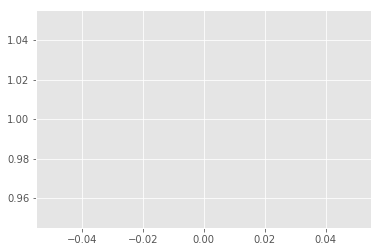

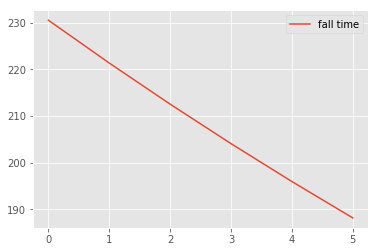

Fall Time:


[230.53364968936185,
 221.35178116734627,
 212.53561504786137,
 204.0705858590868,
 195.94270825382765,
 188.13855390387235]

Fall Time Adj: 0
Sigma Squared: 1.6009e+05
Eta: 0
Zeta: 0
Full Variance: 1.6009e+05
Sigma Squared: 7.7624e+05
Eta: 0
Zeta: 0
Full Variance: 7.7624e+05
Sigma Squared: 1.9347e+06
Eta: 0
Zeta: 0
Full Variance: 1.9347e+06
Sigma Squared: 3.6674e+06
Eta: 0
Zeta: 0
Full Variance: 3.6674e+06
Sigma Squared: 5.981e+06
Eta: 0
Zeta: 0
Full Variance: 5.981e+06
Sigma Squared: 8.8681e+06
Eta: 0
Zeta: 0
Full Variance: 8.8681e+06
------misfit calculations---------
a 1.0
b 1.0
h1 5000.0
z values [1000.83333333 2000.66666667 3000.5        4000.33333333 5000.16666667
 6000.        ]
z_min 1
H 6000
tot_mass 50000.0
q values [16666.66666667 16666.66666667 16666.66666667     0.
     0.             0.        ]
A Matrix [[1.21899347e-09 1.89096175e-07 1.46444450e-07 8.59806481e-08
  5.31460901e-08 3.53809547e-08]]
q values [16666.66666667 16666.66666667 16666.66666667     0.
     0.             0.        ]
Fit Values [0.00561266]
Obs Values [0.0056127]
SSE Values [2.5984001388759496e-13]
----------------------

C:\Users\nmostert\Documents\repos\inversion_project\utils.py:473: RuntimeWarning: divide by zero encountered in double_scalars
  factor_a = (1/((a-1)*(b-1)*(H-h1)))


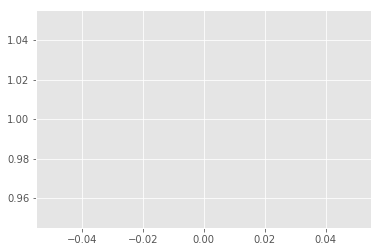

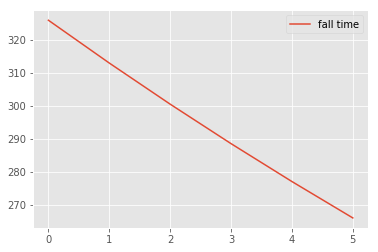

Fall Time:


[326.02381397406356,
 313.0386909823025,
 300.5707492879928,
 288.5993902033437,
 277.10483546067763,
 266.0680945361178]

Fall Time Adj: 0
Sigma Squared: 2.8724e+05
Eta: 0
Zeta: 0
Full Variance: 2.8724e+05
Sigma Squared: 1.4238e+06
Eta: 0
Zeta: 0
Full Variance: 1.4238e+06
Sigma Squared: 3.5878e+06
Eta: 0
Zeta: 0
Full Variance: 3.5878e+06
Sigma Squared: 6.846e+06
Eta: 0
Zeta: 0
Full Variance: 6.846e+06
Sigma Squared: 1.1213e+07
Eta: 0
Zeta: 0
Full Variance: 1.1213e+07
Sigma Squared: 1.6674e+07
Eta: 0
Zeta: 0
Full Variance: 1.6674e+07
------misfit calculations---------
a 1.0
b 1.0
h1 5000.0
z values [1000.83333333 2000.66666667 3000.5        4000.33333333 5000.16666667
 6000.        ]
z_min 1
H 6000
tot_mass 50000.0
q values [16666.66666667 16666.66666667 16666.66666667     0.
     0.             0.        ]
A Matrix [[4.68817732e-08 1.86178911e-07 8.85402037e-08 4.57936854e-08
  2.71229054e-08 1.77747450e-08]]
q values [16666.66666667 16666.66666667 16666.66666667     0.
     0.             0.        ]
Fit Values [0.00536001]
Obs Values [0.00536004]
SSE Values [1.5620926274371753e-13]
---------------------

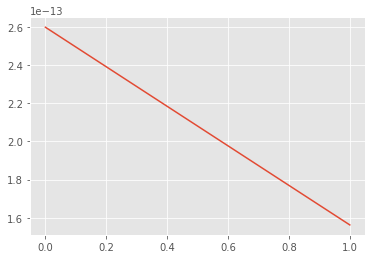

In [49]:
all_point_conts = []
all_phi_conts = []

for j, phi_step in enumerate(test_phi_steps):
    mass_in_phi = test_config["ERUPTION_MASS"] * phi_step["probability"]
    iso_step = phi_step.copy()
    iso_step["probability"] = 1
    misfit, contributions, setup = get_error_contributions(
        observation_phis[j], len(observation_phis[j]), int(test_config["INV_STEPS"]), 
        test_config["VENT_ELEVATION"], test_config["THEO_MAX_COL"], 1, [iso_step], 
        full_inversion_priors, mass_in_phi, column_cap = test_config["THEO_MAX_COL"],
        debug=True)
        
        
    
    print(phi_step["interval"], misfit)
    
    point_contributions = np.sum(contributions, 0)
    phi_contributions = np.sum(contributions, 1)
    all_point_conts += [point_contributions]
    all_phi_conts += [phi_contributions]
    
print("Full Misfit: ", sum(sum(all_point_conts)))
plt.plot(all_phi_conts)
plt.show()

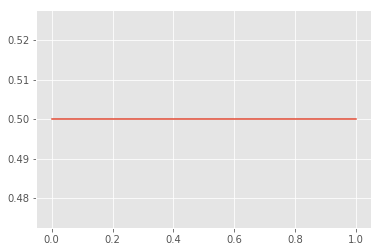

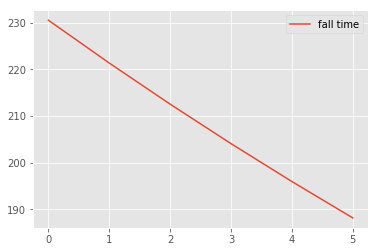

Fall Time:


[230.53364968936185,
 221.35178116734627,
 212.53561504786137,
 204.0705858590868,
 195.94270825382765,
 188.13855390387235]

Fall Time Adj: 0
Sigma Squared: 1.6009e+05
Eta: 0
Zeta: 0
Full Variance: 1.6009e+05
Sigma Squared: 7.7624e+05
Eta: 0
Zeta: 0
Full Variance: 7.7624e+05
Sigma Squared: 1.9347e+06
Eta: 0
Zeta: 0
Full Variance: 1.9347e+06
Sigma Squared: 3.6674e+06
Eta: 0
Zeta: 0
Full Variance: 3.6674e+06
Sigma Squared: 5.981e+06
Eta: 0
Zeta: 0
Full Variance: 5.981e+06
Sigma Squared: 8.8681e+06
Eta: 0
Zeta: 0
Full Variance: 8.8681e+06
------misfit calculations---------
a 1.0
b 1.0
h1 5000.0
z values [1000.83333333 2000.66666667 3000.5        4000.33333333 5000.16666667
 6000.        ]
z_min 1
H 6000
tot_mass 50000.0
q values [16666.66666667 16666.66666667 16666.66666667     0.
     0.             0.        ]
A Matrix [[1.21899347e-09 1.89096175e-07 1.46444450e-07 8.59806481e-08
  5.31460901e-08 3.53809547e-08]]
q values [16666.66666667 16666.66666667 16666.66666667     0.
     0.             0.        ]
Fit Values [0.00561266]
Obs Values [0.0056127]
SSE Values [2.598400138993981e-13]
-----------------------

C:\Users\nmostert\Documents\repos\inversion_project\utils.py:473: RuntimeWarning: divide by zero encountered in double_scalars
  factor_a = (1/((a-1)*(b-1)*(H-h1)))


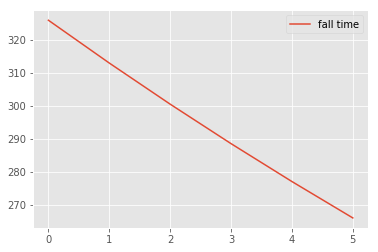

Fall Time:


[326.02381397406356,
 313.0386909823025,
 300.5707492879928,
 288.5993902033437,
 277.10483546067763,
 266.0680945361178]

Fall Time Adj: 0
Sigma Squared: 2.8724e+05
Eta: 0
Zeta: 0
Full Variance: 2.8724e+05
Sigma Squared: 1.4238e+06
Eta: 0
Zeta: 0
Full Variance: 1.4238e+06
Sigma Squared: 3.5878e+06
Eta: 0
Zeta: 0
Full Variance: 3.5878e+06
Sigma Squared: 6.846e+06
Eta: 0
Zeta: 0
Full Variance: 6.846e+06
Sigma Squared: 1.1213e+07
Eta: 0
Zeta: 0
Full Variance: 1.1213e+07
Sigma Squared: 1.6674e+07
Eta: 0
Zeta: 0
Full Variance: 1.6674e+07
------misfit calculations---------
a 1.0
b 1.0
h1 5000.0
z values [1000.83333333 2000.66666667 3000.5        4000.33333333 5000.16666667
 6000.        ]
z_min 1
H 6000
tot_mass 50000.0
q values [16666.66666667 16666.66666667 16666.66666667     0.
     0.             0.        ]
A Matrix [[4.68817732e-08 1.86178911e-07 8.85402037e-08 4.57936854e-08
  2.71229054e-08 1.77747450e-08]]
q values [16666.66666667 16666.66666667 16666.66666667     0.
     0.             0.        ]
Fit Values [0.00536001]
Obs Values [0.00536004]
SSE Values [1.5620926275308238e-13]
---------------------

In [45]:
misfit, contributions, setup = get_error_contributions(
        test_df, len(test_df), int(test_config["INV_STEPS"]), 
        test_config["VENT_ELEVATION"], test_config["THEO_MAX_COL"], 1, test_phi_steps, 
        full_inversion_priors, test_config["ERUPTION_MASS"], column_cap = test_config["THEO_MAX_COL"],
        debug=True)
print("Full misfit", misfit)
point_contributions = np.sum(contributions, 0)
phi_contributions = np.sum(contributions, 1)
print("Point Contributions", point_contributions)
print("Phi Contributions", phi_contributions)

print("Sum of Point Conts:", sum(point_contributions))
print("Sum of Phi Conts:", sum(phi_contributions))

In [16]:


def col_truncnorm(mean, top=config["THEO_MAX_COL"]):
    bottom = 5000
    std = (top - bottom)/4
    standard_a, standard_b = (bottom - mean) / std, (top - mean) / std
    return truncnorm.rvs(standard_a, standard_b, loc=mean, scale=std)

def lognorm(prior, bottom=0):
    std_norm = norm.rvs()
    std_lognorm = np.exp(std_norm)
    lognorm = bottom + (prior-bottom)*std_lognorm
    return lognorm

def normal(prior):
    std_norm = norm.rvs()
    normal = prior*std_norm
    return normal

def uninformed(bottom, top):
    unif = uniform.rvs(loc = bottom, scale = (top-bottom))
    return unif


In [17]:
full_inversion_priors = {
    "a": 1.00002,
    "b": 1.13405,
    "h1": 44908,
    "u": 2.60482,
    "v": 5.33615,
    "D": 5999.9,
    "ftt": 6458,
    "eta": 2.34894,
    "zeta": 0
}

phi_probs = [
    0.058657896918929336,
    0.15114329504320803,
    0.15644352749157492,
    0.15138125134809738,
    0.17100876050061856,
    0.1814490666782764,
    0.06799943098150356,
    0.01682410991463832,
    0.045092661123153584
]

,invert,sample_function,value
a,False,<function uninformed at 0x0000020DD4113AE8>,"[1.00002, 5]"
b,False,<function uninformed at 0x0000020DD4113AE8>,"[1.13405, 5]"
h1,False,<function uninformed at 0x0000020DD4113AE8>,"[44908, 44915.0]"
u,False,<function uninformed at 0x0000020DD4113AE8>,"[2.60482, 10]"
v,False,<function uninformed at 0x0000020DD4113AE8>,"[5.33615, 10]"
D,False,<function uninformed at 0x0000020DD4113AE8>,"[5999.9, 6000]"
ftt,False,<function uninformed at 0x0000020DD4113AE8>,"[6458.0, 10000]"
eta,False,<function uninformed at 0x0000020DD4113AE8>,"[2.34894, 10]"
zeta,False,<function uninformed at 0x0000020DD4113AE8>,"[0, 0]"


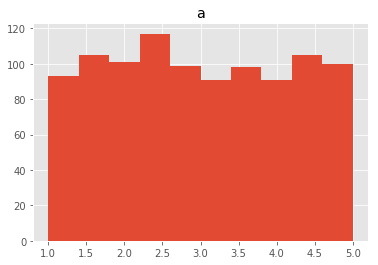

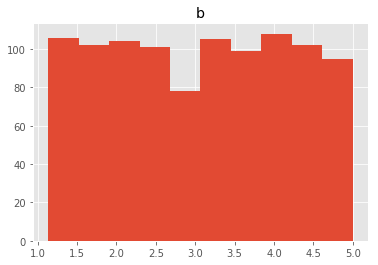

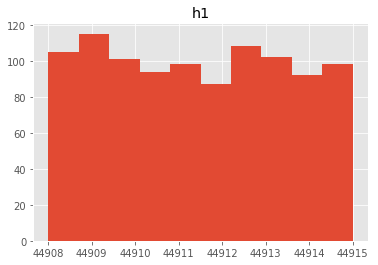

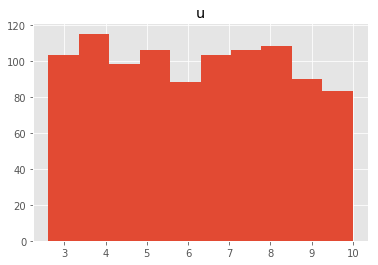

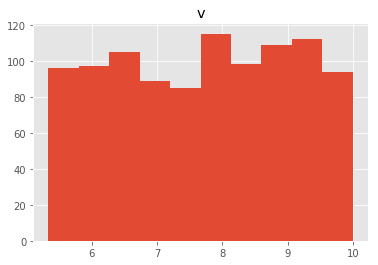

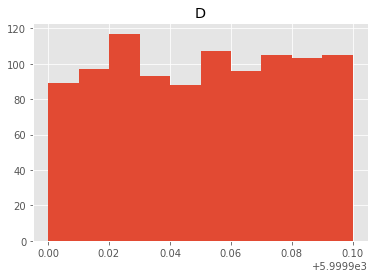

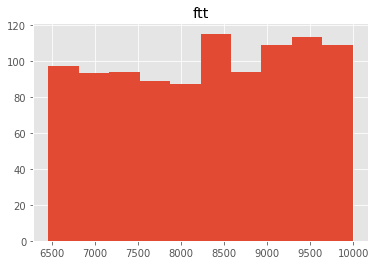

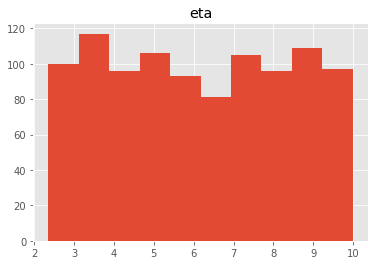

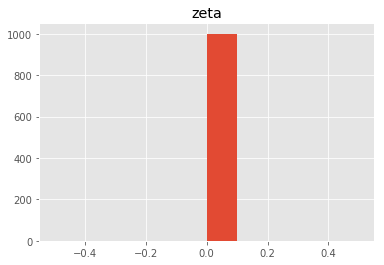

In [18]:
# param_config = {
#     "a": {
#         "value":[1.01, 5],
#         "invert":True,
#         "sample_function": uninformed
#     },
#     "b": {
#         "value":[1.01, 5],
#         "invert":True,
#         "sample_function": uninformed
#     },
#     "h1": {
#         "value":[5000, config["THEO_MAX_COL"]],
#         "invert":True,
#         "sample_function": uninformed
#     },
#     "u": {
#         "value":[full_inversion_priors["u"], 10],
#         "invert":False,
#         "sample_function": uninformed
#     },
#     "v": {
#         "value":[full_inversion_priors["v"], 10],
#         "invert":False,
#         "sample_function": uninformed
#     },
#     "D": {
#         "value":[full_inversion_priors["D"], 6000],
#         "invert":False,
#         "sample_function": uninformed
#     },
#     "ftt": {
#         "value":[config["FALL_TIME_THRESHOLD"], 10000],
#         "invert":False,
#         "sample_function": uninformed
#     },
#     "eta": {
#         "value":[0.01, 10],
#         "invert":True,
#         "sample_function": uninformed
#     },
#     "zeta": {
#         "value":[0, 0],
#         "invert":False,
#         "sample_function": uninformed
#     },
# }


param_config = {
    "a": {
        "value":[full_inversion_priors["a"], 5],
        "invert":False,
        "sample_function": uninformed
    },
    "b": {
        "value":[full_inversion_priors["b"], 5],
        "invert":False,
        "sample_function": uninformed
    },
    "h1": {
        "value":[full_inversion_priors["h1"], config["THEO_MAX_COL"]],
        "invert":False,
        "sample_function": uninformed
    },
    "u": {
        "value":[full_inversion_priors["u"], 10],
        "invert":False,
        "sample_function": uninformed
    },
    "v": {
        "value":[full_inversion_priors["v"], 10],
        "invert":False,
        "sample_function": uninformed
    },
    "D": {
        "value":[full_inversion_priors["D"], 6000],
        "invert":False,
        "sample_function": uninformed
    },
    "ftt": {
        "value":[config["FALL_TIME_THRESHOLD"], 10000],
        "invert":False,
        "sample_function": uninformed
    },
    "eta": {
        "value":[full_inversion_priors["eta"], 10],
        "invert":False,
        "sample_function": uninformed
    },
    "zeta": {
        "value":[0, 0],
        "invert":False,
        "sample_function": uninformed
    },
}

param_config_df = pd.DataFrame(param_config)
display.display(param_config_df.T)

for key, val in param_config.items():
    x = [val["sample_function"](*val["value"]) for i in range(1000)]
    plt.hist(x)
    plt.title(key)
    plt.show()

